# Batch AL on SAR Data
This code runs some of the batch active learning things we've been working on. The main purpose is to load the SAR datasets and run code on them. 

**Change things to encode_pretrained and this can use the pretrained stuff**

Use the encode_pretrained
1. Current results are for fully trained CNN embeddings
2. The transfer learning is fully supervised from image net
3. Need to make updates in the cell below "Load datasets and generate graph learning objects"

In [1]:
import graphlearning.active_learning as al
import graphlearning as gl
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import torchvision.models as torch_models
import timeit
import torch
import random

import utils
import batch_active_learning as bal


In [2]:
from importlib import reload
reload(bal)
reload(utils)

<module 'utils' from '/Users/jameschapman/Documents/GitHub/SAR_BAL/utils.py'>

## User Input

In [3]:
#Pick one of 'mstar', 'open_sar', 'fusar', 'all'
dataset_chosen = 'fusar'

#This uses a CNNVAE to get embeddings
# **I think this actually uses the fully trained and not a CNNVAE
#Currently we always use the VAE for MSTAR since the knn_data is already stored for this
use_fully_trained_features = False
just_transfer              = True
transfer_and_train         = False

assert(use_fully_trained_features + just_transfer + transfer_and_train == 1)

#If you specify this, then it will use a specific trained NN for embeddings
#If none, it will pick the ones deemed optimal from prior testing
#  I recommend using None
transfer_encoding = None

#Determines the number of points in the coreset
#Larger values correspond to smaller coresets
density_radius_param = .5

## Fixed Parameters

In [4]:
#knn number, etc. 
knn_num = 20

if not use_fully_trained_features and transfer_encoding == None:
    if dataset_chosen == 'mstar':
        transfer_encoding = None
    if dataset_chosen == 'open_sar':
        transfer_encoding = 'AlexNet'
    if dataset_chosen == 'fusar':
        transfer_encoding = 'ShuffleNet'

## Load Datasets and Generate Graph Learning Objects

In [7]:
start = timeit.default_timer()
torch.cuda.empty_cache()

if dataset_chosen == 'open_sar':
  #Load labels
  data, labels = utils.load_dataset('open_sar_ship', return_torch = False, concatenate = True)
elif dataset_chosen == 'fusar':
  #Load labels
  data, labels = utils.load_dataset('fusar', return_torch = False, concatenate = True)
else:
  assert False, "Chosen dataset could not be loaded. Check for typos"

#Mimic that we know a percentage of data, and don't know for the rest
#Do transfer learning merely using these
percent_known_data = 0
if dataset_chosen == 'open_sar':
  percent_known_data = 0.07
else:
  percent_known_data == 0.07
known_data_ind = gl.trainsets.generate(labels, rate=percent_known_data).tolist()
known_data = data[known_data_ind]
known_labels = labels[known_data_ind]

# print(len(known_data))

#Generate the initial set
initial = gl.trainsets.generate(labels, rate=1).tolist()

#Percent of known data to use as training data for transfer learning
training_percent = 0.7
transfer_train_ind = random.sample(range(len(known_data)), round(len(known_data)*training_percent))
transfer_testing_ind = np.array([ind for ind in range(len(known_data)) if ind not in transfer_train_ind]).astype(int)

#Convert to torch for use
known_data = torch.from_numpy(known_data)
known_labels = torch.from_numpy(known_labels)


#print(len(transfer_testing_ind))
training_data = known_data[transfer_train_ind]
training_label = known_labels[transfer_train_ind]
testing_data = known_data[transfer_testing_ind]
testing_label = known_labels[transfer_testing_ind]

print(len(training_data))
print(len(testing_data))

data_info=[training_data, training_label, testing_data, testing_label]

        
if dataset_chosen == 'open_sar':
    #Load encoded dataset
    if use_fully_trained_features:
        X = utils.encode_dataset('open_sar_ship','./models/open_sar_ship_CNN.pt')
    elif just_transfer:
        X = utils.encode_pretrained('open_sar_ship', 'AlexNet', transformed=True)
    else:
        X = utils.encode_transfer_learning('open_sar_ship', model_type='AlexNet', transfer_batch_size=64, epochs=30, data_info=data_info)
    #Load labels
    _, labels = utils.load_dataset('open_sar_ship', return_torch = False, concatenate = True)
    knn_data = gl.weightmatrix.knnsearch(X, knn_num, method='annoy', similarity='angular')
elif dataset_chosen == 'fusar':
    #Load encoded dataset
    if use_fully_trained_features:
        X, labels = utils.encode_dataset('fusar','./models/fusar_CNN.pt')
    elif just_transfer:
        X, labels = utils.encode_pretrained('fusar', 'ShuffleNet', normalized=True, transformed=True)
    else:
        X, labels = utils.encode_transfer_learning('fusar', model_type='ShuffleNet', transfer_batch_size=64, epochs=30, data_info=data_info)
    #Load labels
    #_, labels = utils.load_dataset('fusar', return_torch = False, concatenate = True)
    knn_data = gl.weightmatrix.knnsearch(X, knn_num, method='annoy', similarity='angular')
elif dataset_chosen == 'all':
    pass
else:
    assert False, "Chosen dataset could not be loaded. Check for typos"

print("Constructing Graph Learning Objects")
W = gl.weightmatrix.knn(X, knn_num, kernel = 'gaussian', knn_data=knn_data)
G = gl.graph(W)
end = timeit.default_timer()

print(X.shape)

print("Complete")
print(f"Time taken = {end - start}")

0
0


Using cache found in /Users/jameschapman/.cache/torch/hub/pytorch_vision_v0.10.0


Constructing Graph Learning Objects
(4856, 1024)
Complete
Time taken = 41.242593916000004


## Generate Coreset

In [8]:
#Use the percent radius because it should be more robust across datasets
coreset = bal.coreset_dijkstras(G, rad = .2, DEBUGGING=False, data = X, initial=initial, 
                                density_info = (True, density_radius_param, 1), knn_data=knn_data)
print("Coreset Size = {}\t Percent of data = {}%".format(len(coreset), round(100 * len(coreset) / len(X), 2)))
print("Coreset = ", coreset)
print(labels[coreset])

Coreset Size = 20	 Percent of data = 0.41%
Coreset =  [587, 39, 830, 3895, 2339, 3979, 3655, 2588, 1302, 3100, 370, 1312, 2772, 4721, 918, 3586, 657, 4555, 586, 4681]
[0 1 2 3 4 4 4 2 4 3 4 0 2 2 2 4 4 0 4 4]


## Perform Batch AL

Feature Extraction OpenSarShip (Sometimes the accuracy will be a bit lower than SoTA)

In [9]:
acq_fun_list = ['uc', 'vopt', 'mc', 'mcvopt']
# acq_fun_list = ['uc']
max_new_samples = 690
batchsize=15

L_time = []
L_num_labels = []
L_acc = []
L_names = []

al_mtd = 'local_max'
method='Laplace'

for acq_fun in acq_fun_list:

    num_iter = int(max_new_samples/batchsize)

    if acq_fun == 'vopt' or acq_fun == 'mcvopt':
         num_iter += 1


    print(acq_fun, al_mtd)
    start = timeit.default_timer() 
    _, list_num_labels, list_acc = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=num_iter, method=method,
                            display=False, use_prior=False, al_mtd=al_mtd, debug=False,
                            acq_fun=acq_fun, knn_data=knn_data, mtd_para=None,
                            savefig=False, savefig_folder='../BAL_figures', batchsize=batchsize,
                            dist_metric='angular', q=10, thresholding=0, randseed=0)
    stop = timeit.default_timer()
    L_time.append(stop - start)
    L_num_labels.append(list_num_labels)
    L_acc.append(list_acc)
    L_names.append(acq_fun)
      

uc local_max
vopt local_max
mc local_max
mcvopt local_max


uc highest accuracy: 6816.208393632416%


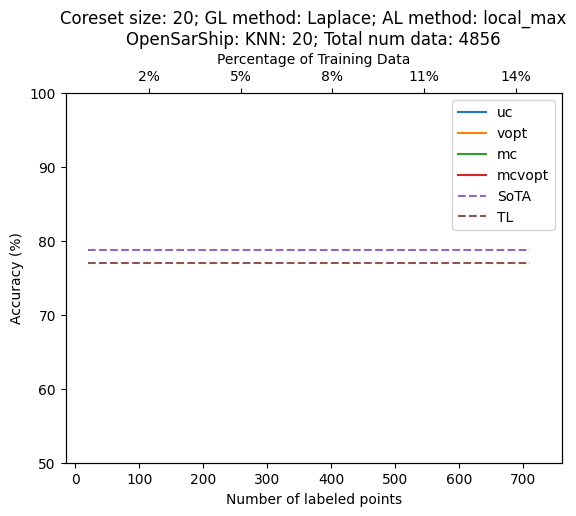

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

print("uc highest accuracy: " + str(100*L_acc[0][-1]) + "%")
for i in range(len(L_acc)):
    ax1.plot(L_num_labels[i], 100*L_acc[i], label=L_names[i])
ax1.plot(L_num_labels[0], 78.72 * np.ones_like(L_num_labels[0]), label='SoTA', linestyle='--')
ax1.plot(L_num_labels[0], 76.99 * np.ones_like(L_num_labels[0]), label='TL', linestyle='--')
ax1.legend()
ax1.set_xlabel(r"Number of labeled points")
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim((50, 100))

title_str = 'Coreset size: ' + str(len(coreset)) + '; GL method: ' + method + '; AL method: ' + al_mtd + '\n'
title_str += 'OpenSarShip: KNN: ' + str(knn_num) + '; Total num data: ' + str(X.shape[0])

plt.title(title_str)

new_tick_locations = np.linspace(0.05, 0.3, 5) * 2296

def tick_function(X, n):
    V = X / n
    return ["%d%%" % (100*z) for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations, X.shape[0]))
ax2.set_xlabel(r"Percentage of Training Data")
# plt.savefig(os.path.join('../BAL_figures', 'OpenSarShip_diff_acq_' + al_mtd + '.png'), bbox_inches='tight')
plt.show()

Feature Extraction Fusar

In [11]:
acq_fun_list = ['uc', 'vopt', 'mc', 'mcvopt']
# acq_fun_list = ['uc']
max_new_samples = 2910
batchsize=15

L_time = []
L_num_labels = []
L_acc = []
L_names = []

al_mtd = 'local_max'
method='Laplace'

for acq_fun in acq_fun_list:

    num_iter = int(max_new_samples/batchsize)

    if acq_fun == 'vopt' or acq_fun == 'mcvopt':
         num_iter += 1


    print(acq_fun, al_mtd)
    start = timeit.default_timer() 
    print(X.shape)
    _, list_num_labels, list_acc = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=num_iter, method=method,
                            display=False, use_prior=False, al_mtd=al_mtd, debug=False,
                            acq_fun=acq_fun, knn_data=knn_data, mtd_para=None,
                            savefig=False, savefig_folder='../BAL_figures', batchsize=batchsize,
                            dist_metric='angular', q=10, thresholding=0, randseed=0)
    stop = timeit.default_timer()
    L_time.append(stop - start)
    L_num_labels.append(list_num_labels)
    L_acc.append(list_acc)
    L_names.append(acq_fun)
      

uc local_max
(4856, 1024)
vopt local_max
(4856, 1024)
mc local_max
(4856, 1024)
mcvopt local_max
(4856, 1024)


uc highest accuracy: 8873.312564901351%


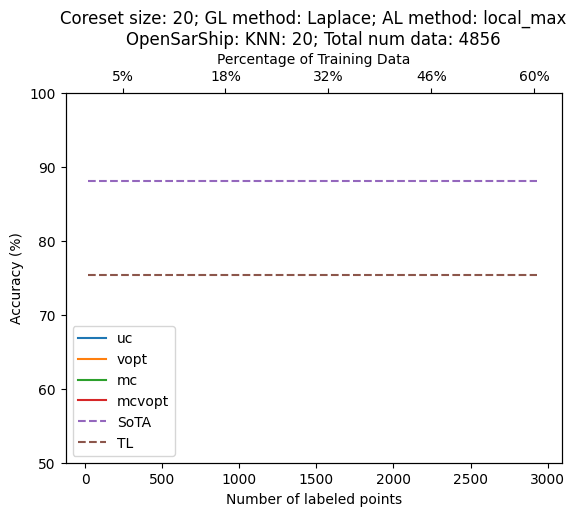

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

print("uc highest accuracy: " + str(100*L_acc[0][-1]) + "%")
for i in range(len(L_acc)):
    ax1.plot(L_num_labels[i], 100*L_acc[i], label=L_names[i])
ax1.plot(L_num_labels[0], 88.16 * np.ones_like(L_num_labels[0]), label='SoTA', linestyle='--')
ax1.plot(L_num_labels[0], 75.36 * np.ones_like(L_num_labels[0]), label='TL', linestyle='--')
ax1.legend()
ax1.set_xlabel(r"Number of labeled points")
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim((50, 100))

title_str = 'Coreset size: ' + str(len(coreset)) + '; GL method: ' + method + '; AL method: ' + al_mtd + '\n'
title_str += 'OpenSarShip: KNN: ' + str(knn_num) + '; Total num data: ' + str(X.shape[0])

plt.title(title_str)

new_tick_locations = np.linspace(0.05, 0.6, 5) * 4856

def tick_function(X, n):
    V = X / n
    return ["%d%%" % (100*z) for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations, X.shape[0]))
ax2.set_xlabel(r"Percentage of Training Data")
# plt.savefig(os.path.join('../BAL_figures', 'OpenSarShip_diff_acq_' + al_mtd + '.png'), bbox_inches='tight')
plt.show()

Transfer Learning OpenSarShip

In [13]:
acq_fun_list = ['uc', 'vopt', 'mc', 'mcvopt']
# acq_fun_list = ['uc']
max_new_samples = 690
batchsize=15

L_time = []
L_num_labels = []
L_acc = []
L_names = []

al_mtd = 'local_max'
method='Laplace'

for acq_fun in acq_fun_list:

    num_iter = int(max_new_samples/batchsize)

    if acq_fun == 'vopt' or acq_fun == 'mcvopt':
         num_iter += 1


    print(acq_fun, al_mtd)
    start = timeit.default_timer() 
    _, list_num_labels, list_acc = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=num_iter, method=method,
                            display=False, use_prior=False, al_mtd=al_mtd, debug=False,
                            acq_fun=acq_fun, knn_data=knn_data, mtd_para=None,
                            savefig=False, savefig_folder='../BAL_figures', batchsize=batchsize,
                            dist_metric='angular', q=10, thresholding=0, randseed=0)
    stop = timeit.default_timer()
    L_time.append(stop - start)
    L_num_labels.append(list_num_labels)
    L_acc.append(list_acc)
    L_names.append(acq_fun)
      

uc local_max
vopt local_max
mc local_max
mcvopt local_max


uc highest accuracy: 6816.208393632416%


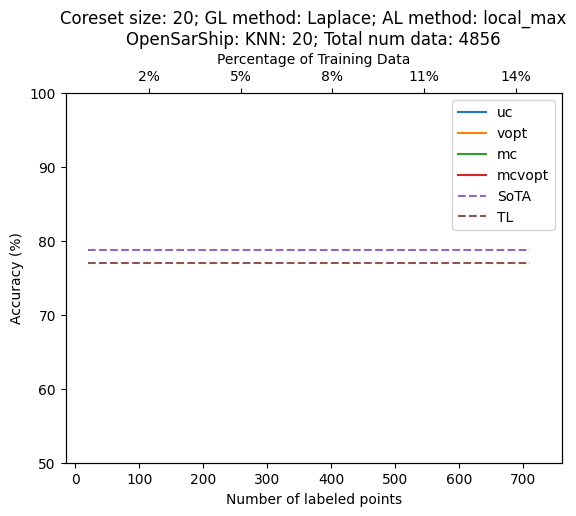

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

print("uc highest accuracy: " + str(100*L_acc[0][-1]) + "%")
for i in range(len(L_acc)):
    ax1.plot(L_num_labels[i], 100*L_acc[i], label=L_names[i])
ax1.plot(L_num_labels[0], 78.72 * np.ones_like(L_num_labels[0]), label='SoTA', linestyle='--')
ax1.plot(L_num_labels[0], 76.99 * np.ones_like(L_num_labels[0]), label='TL', linestyle='--')
ax1.legend()
ax1.set_xlabel(r"Number of labeled points")
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim((50, 100))

title_str = 'Coreset size: ' + str(len(coreset)) + '; GL method: ' + method + '; AL method: ' + al_mtd + '\n'
title_str += 'OpenSarShip: KNN: ' + str(knn_num) + '; Total num data: ' + str(X.shape[0])

plt.title(title_str)

new_tick_locations = np.linspace(0.05, 0.3, 5) * 2296

def tick_function(X, n):
    V = X / n
    return ["%d%%" % (100*z) for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations, X.shape[0]))
ax2.set_xlabel(r"Percentage of Training Data")
# plt.savefig(os.path.join('../BAL_figures', 'OpenSarShip_diff_acq_' + al_mtd + '.png'), bbox_inches='tight')
plt.show()

Transfer Learning Fusar

In [15]:
acq_fun_list = ['uc', 'vopt', 'mc', 'mcvopt']
# acq_fun_list = ['uc']
max_new_samples = 2910
batchsize=15

L_time = []
L_num_labels = []
L_acc = []
L_names = []

al_mtd = 'local_max'
method='Laplace'

for acq_fun in acq_fun_list:

    num_iter = int(max_new_samples/batchsize)

    if acq_fun == 'vopt' or acq_fun == 'mcvopt':
         num_iter += 1


    print(acq_fun, al_mtd)
    start = timeit.default_timer() 
    print(X.shape)
    _, list_num_labels, list_acc = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=num_iter, method=method,
                            display=False, use_prior=False, al_mtd=al_mtd, debug=False,
                            acq_fun=acq_fun, knn_data=knn_data, mtd_para=None,
                            savefig=False, savefig_folder='../BAL_figures', batchsize=batchsize,
                            dist_metric='angular', q=10, thresholding=0, randseed=0)
    stop = timeit.default_timer()
    L_time.append(stop - start)
    L_num_labels.append(list_num_labels)
    L_acc.append(list_acc)
    L_names.append(acq_fun)
      

uc local_max
(4856, 1024)
vopt local_max
(4856, 1024)
mc local_max
(4856, 1024)
mcvopt local_max
(4856, 1024)


uc highest accuracy: 8873.312564901351%


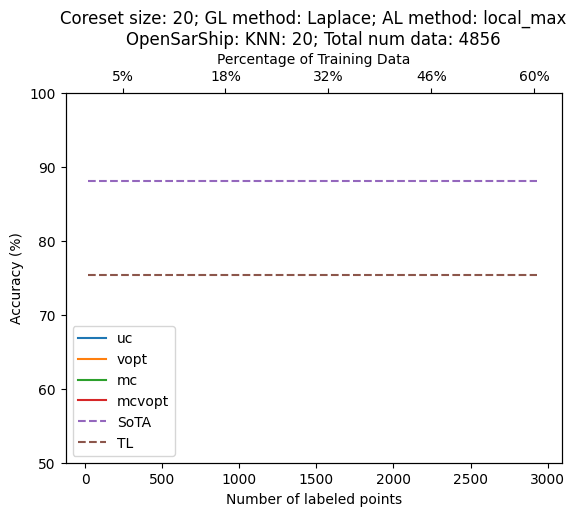

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

print("uc highest accuracy: " + str(100*L_acc[0][-1]) + "%")
for i in range(len(L_acc)):
    ax1.plot(L_num_labels[i], 100*L_acc[i], label=L_names[i])
ax1.plot(L_num_labels[0], 88.16 * np.ones_like(L_num_labels[0]), label='SoTA', linestyle='--')
ax1.plot(L_num_labels[0], 75.36 * np.ones_like(L_num_labels[0]), label='TL', linestyle='--')
ax1.legend()
ax1.set_xlabel(r"Number of labeled points")
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim((50, 100))

title_str = 'Coreset size: ' + str(len(coreset)) + '; GL method: ' + method + '; AL method: ' + al_mtd + '\n'
title_str += 'OpenSarShip: KNN: ' + str(knn_num) + '; Total num data: ' + str(X.shape[0])

plt.title(title_str)

new_tick_locations = np.linspace(0.05, 0.6, 5) * 4856

def tick_function(X, n):
    V = X / n
    return ["%d%%" % (100*z) for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations, X.shape[0]))
ax2.set_xlabel(r"Percentage of Training Data")
# plt.savefig(os.path.join('../BAL_figures', 'OpenSarShip_diff_acq_' + al_mtd + '.png'), bbox_inches='tight')
plt.show()